# Prétraitement des données

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.base import BaseEstimator
import pandas as pd
import numpy as np
from pandas import DataFrame
import mlflow
import mlflow.sklearn

In [2]:
random_state = 42

In [3]:
housing = fetch_california_housing(as_frame=True)
X = housing.data
y = housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Utils

In [13]:
def train_model(model: BaseEstimator, params_grid: dict, X_train: DataFrame, y_train: DataFrame, nb_jobs: int = None) -> tuple[BaseEstimator, dict]:
    """
    Entraîne un modèle en utilisant GridSearchCV pour trouver les meilleurs hyperparamètres et retourne le meilleur estimateur et ses paramètres.

    Paramètres :
    model (BaseEstimator) : Le modèle de base à entraîner.
    params_grid (dict) : Dictionnaire avec les noms des paramètres (str) comme clés et des listes de valeurs des paramètres à essayer.
    X_train (DataFrame) : Données de caractéristiques d'entraînement.
    y_train (DataFrame) : Données d'étiquettes d'entraînement.
    nb_jobs (int, optionnel) : Nombre de travaux à exécuter en parallèle. None signifie 1 sauf dans un contexte joblib.parallel_backend. -1 signifie utiliser tous les processeurs.

    Retourne :
    tuple[BaseEstimator, dict] : Le meilleur estimateur et les paramètres du meilleur modèle trouvé par GridSearchCV.
    """
    # Définir la recherche
    search = GridSearchCV(model, params_grid, scoring='neg_mean_squared_error', n_jobs=nb_jobs)
    
    # Ajuster la recherche
    search.fit(X_train, y_train)
    best_estimator = search.best_estimator_
    best_estimator.fit(X_train, y_train)
    return best_estimator, search.best_params_


In [14]:
def evaluate_model(model: BaseEstimator, X_test: DataFrame, y_test: DataFrame) -> dict:
    """
    Évalue un modèle en utilisant les données de test et retourne les scores de différentes métriques d'évaluation.

    Paramètres :
    model (BaseEstimator) : Le modèle à évaluer.
    X_test (DataFrame) : Données de caractéristiques de test.
    y_test (DataFrame) : Données d'étiquettes de test.

    Retourne :
    dict : Un dictionnaire contenant les scores de l'erreur quadratique moyenne (mean_squared_error), de l'erreur absolue moyenne (mean_absolute_error) et du coefficient de détermination (r2).
    """
    y_pred = model.predict(X_test)
    scores = {
        "mean_squared_error": mean_squared_error(y_test, y_pred),
        "mean_absolute_error": mean_absolute_error(y_test, y_pred),
        "r2": r2_score(y_test, y_pred),
    }

    return scores

In [15]:
def log_metrics(run_name, params, metrics, tags=None) -> None:
    """
    Enregistre les paramètres, les métriques et éventuellement des tags pour une expérimentation avec MLflow.

    Paramètres :
    run_name (str) : Le nom de la session d'expérimentation.
    params (dict) : Dictionnaire contenant les paramètres à enregistrer.
    metrics (dict) : Dictionnaire contenant les métriques à enregistrer.
    tags (dict, optionnel) : Dictionnaire contenant les tags à enregistrer.

    Retourne :
    None
    """
    rel_path = "mlflow.db"
    mlflow.set_tracking_uri(f"sqlite:///{rel_path}")
    mlflow.set_experiment("Imo")
    with mlflow.start_run(run_name=run_name):
        mlflow.log_params(params)
        mlflow.log_metrics(metrics)
        if tags:
            mlflow.set_tags(tags)


In [16]:
def train_evalute_log(model: BaseEstimator, params_grid: dict, X_train: DataFrame, y_train: DataFrame,
                       X_test: DataFrame, y_test: DataFrame, run_name: str, tags: dict = None, n_jobs: int = None) -> None:
    """
    Entraîne un modèle, l'évalue et enregistre les métriques et paramètres de l'expérience avec MLflow.

    Paramètres :
    model (BaseEstimator) : Le modèle de base à entraîner.
    params_grid (dict) : Dictionnaire avec les noms des paramètres (str) comme clés et des listes de valeurs des paramètres à essayer.
    X_train (DataFrame) : Données de caractéristiques d'entraînement.
    y_train (DataFrame) : Données d'étiquettes d'entraînement.
    X_test (DataFrame) : Données de caractéristiques de test.
    y_test (DataFrame) : Données d'étiquettes de test.
    run_name (str) : Le nom de la session d'expérimentation.
    tags (dict, optionnel) : Dictionnaire contenant les tags à enregistrer.
    n_jobs (int, optionnel) : Nombre de travaux à exécuter en parallèle. None signifie 1 sauf dans un contexte joblib.parallel_backend. -1 signifie utiliser tous les processeurs.

    Retourne :
    None
    """
    best_estimator, best_params = train_model(model, params_grid, X_train, y_train, n_jobs)
    metrics = evaluate_model(best_estimator, X_test, y_test)
    log_metrics(run_name, best_params, metrics, tags)


# Linear Model

In [17]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)
scores = evaluate_model(lr, X_test, y_test)
log_metrics("LinearRegression", {}, scores)

2025/01/17 19:24:37 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/01/17 19:24:37 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

In [19]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
scores = evaluate_model(lr, X_test_scaled, y_test)
log_metrics("LinearRegression_scaled", {}, scores)

Séléction de variable pour le modèle linéaire

In [20]:
mod_seq_backwark = SequentialFeatureSelector(
    estimator=LinearRegression(), direction="backward", n_features_to_select="auto", cv=3,
)
mod_seq_forward = SequentialFeatureSelector(
    estimator=LinearRegression(), direction="forward", n_features_to_select="auto", cv=3
)
mod_seqs = { 'backward': mod_seq_backwark, 
'forward': mod_seq_forward
}
for mode, mod_seq in mod_seqs.items():
    X_train_seq = mod_seq.fit_transform(X_train, y_train)
    model = LinearRegression()
    model.fit(X_train_seq, y_train)
    X_test_seq = mod_seq.transform(X_test)
    scores = evaluate_model(model, X_test_seq, y_test)
    log_metrics(f"LinearRegression_{mode}", {}, scores, {"features": X.columns[mod_seq.get_support()].to_list()})


In [21]:
mod_seq_backwark = SequentialFeatureSelector(
    estimator=LinearRegression(), direction="backward", n_features_to_select="auto", cv=3,
)
mod_seq_forward = SequentialFeatureSelector(
    estimator=LinearRegression(), direction="forward", n_features_to_select="auto", cv=3,
)
mod_seqs = { 'backward': mod_seq_backwark, 
'forward': mod_seq_forward
}
for mode, mod_seq in mod_seqs.items():
    X_train_seq = mod_seq.fit_transform(X_train_scaled, y_train)
    model = LinearRegression()
    model.fit(X_train_seq, y_train)
    X_test_seq = mod_seq.transform(X_test_scaled)
    scores = evaluate_model(model, X_test_seq, y_test)
    log_metrics(f"LinearRegression_scaled_{mode}", {}, scores, {"features": X.columns[mod_seq.get_support()].to_list()})

In [22]:
params_grid = { "alpha": np.logspace(-3, 3, 50) }

In [23]:
train_evalute_log(Ridge(random_state=random_state), params_grid, X_train, y_train, X_test, y_test, "Ridge")

In [24]:
train_evalute_log(Ridge(random_state=random_state), params_grid, X_train_scaled, y_train, X_test_scaled, y_test, "Ridge_scaled")

In [25]:
train_evalute_log(Lasso(random_state=random_state), params_grid, X_train, y_train, X_test, y_test, "Lasso")

In [26]:
train_evalute_log(Lasso(random_state=random_state), params_grid, X_train_scaled, y_train, X_test_scaled, y_test, "Lasso_scaled")

In [27]:
params_grid = { "alpha": np.logspace(-3, 3, 50), "l1_ratio": np.linspace(0.001, 0.999, 50) }

In [28]:
train_evalute_log(ElasticNet(random_state=random_state), params_grid, X_train, y_train, X_test, y_test, "ElasticNet", n_jobs=2)

In [29]:
train_evalute_log(ElasticNet(random_state=random_state), params_grid, X_train_scaled, y_train, X_test_scaled, y_test, "ElasticNet_scaled", n_jobs=2)

# tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [31]:
params_grid = { "max_depth": [None, 3, 5, 7, 9, 11, 13, 15] }

In [32]:
train_evalute_log(DecisionTreeRegressor(random_state=random_state), params_grid, X_train, y_train, X_test, y_test, "DecisionTree")

In [33]:
params_grid = { "max_depth": [None, 3, 5],
                "n_estimators": [100, 150] }

In [34]:
train_evalute_log(RandomForestRegressor(random_state=random_state), params_grid, X_train, y_train, X_test, y_test, "RandomForest", n_jobs=2)

In [35]:
params_grid = { "max_depth": [None, 3, 5],
                "n_estimators": [100, 150],
                 "learning_rate": [0.1, 0.15] }

In [36]:
train_evalute_log(GradientBoostingRegressor(random_state=random_state), params_grid, X_train, y_train, X_test, y_test, "GradientBoosting", n_jobs=2)

# Résultats

In [53]:
from PIL import Image
from IPython.display import display

**mean_squared_error**

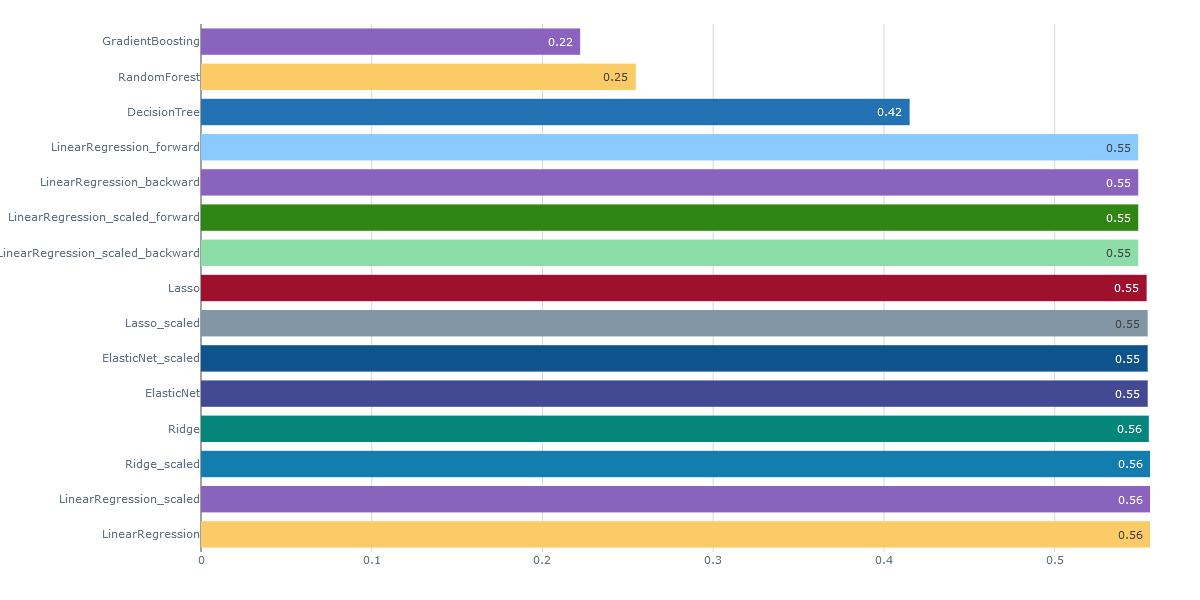

In [54]:
image = Image.open(f"images/mean_squared_error.png")
display(image)

L'erreur quadratique moyenne (MSE) entre les valeurs prédites et les valeurs réelles met en évidence les modèles qui commettent des erreurs importantes, en les pénalisant fortement. À partir de ce graphique, nous pouvons conclure que le modèle avec le meilleur pouvoir prédictif est le Gradient Boosting.

De manière générale, il est également observé que les modèles basés sur des arbres surpassent les modèles linéaires dans le cadre de ce projet. De plus, il est intéressant de noter que les modèles linéaires entraînés sur des données standardisées présentent des performances inférieures à ceux entraînés sur les données brutes. 

**mean_absolute_error.png**

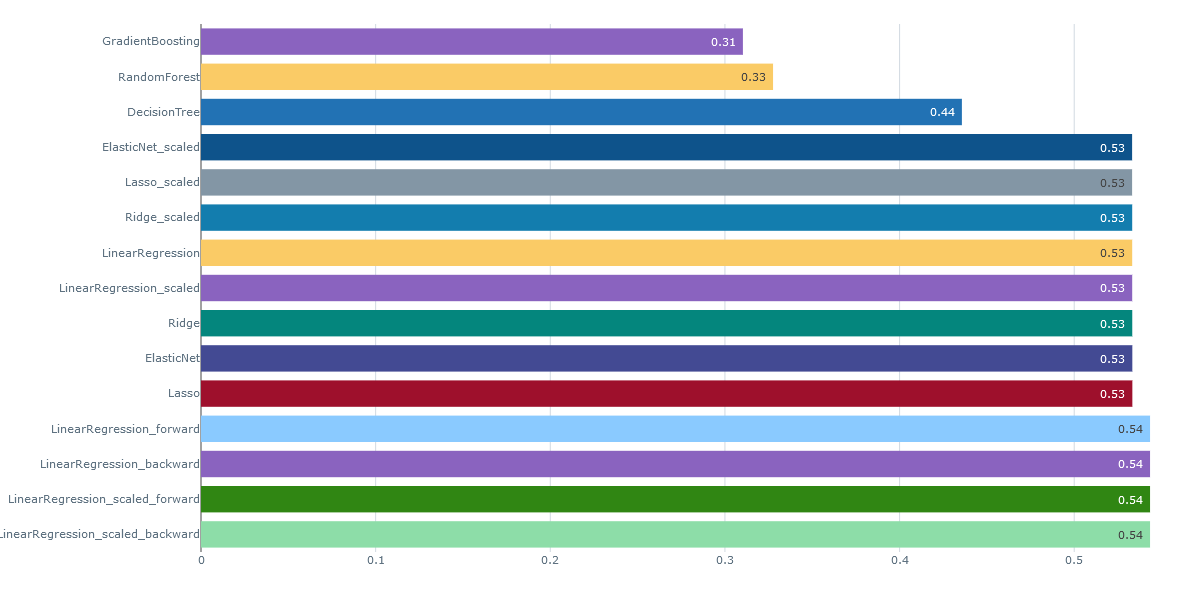

In [55]:
image = Image.open(f"images/mean_absolute_error.png")
display(image)

La moyenne des erreurs absolues (MAE) entre les valeurs réelles et les prédictions se montre plus robuste face aux valeurs extrêmes. À partir de ce graphique, nous pouvons conclure que le modèle le plus résilient face aux valeurs extrêmes est le Gradient Boosting.

De manière générale, il est également observé que les modèles basés sur des arbres continuent de surpasser les modèles linéaires dans le cadre de ce projet. Par ailleurs, il est intéressant de noter que, contrairement aux résultats précédents, les modèles linéaires entraînés sur des données standardisées offrent des performances supérieures à ceux entraînés sur des données brutes en termes de robustesse face aux valeurs manquantes.

**r2**

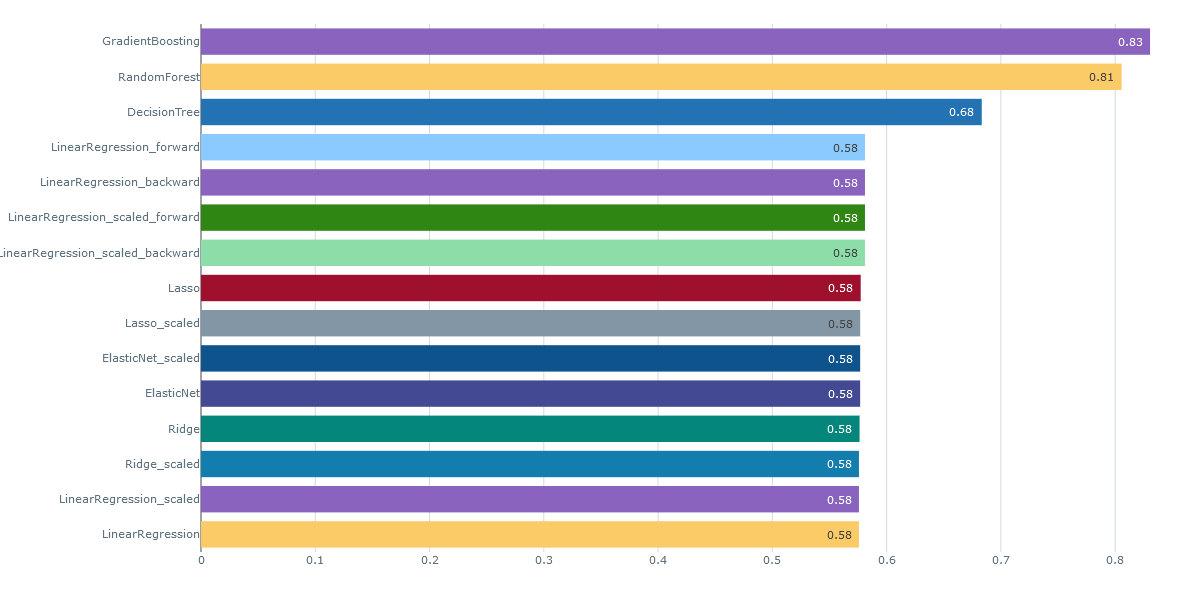

In [56]:
image = Image.open(f"images/r2.png")
display(image)

Le coefficient de détermination r2 reflète la proportion de variance des données réelles expliquée par les modèles prédictifs. À partir de ce graphique, nous constatons un comportement similaire à celui observé avec l'erreur quadratique moyenne (MSE). Le modèle Gradient Boosting se distingue une fois de plus par son meilleur pouvoir explicatif.

De manière générale, les modèles basés sur des arbres surpassent nettement les modèles linéaires dans ce projet. Par ailleurs, il est confirmé que les modèles linéaires entraînés sur des données brutes affichent de meilleures performances que ceux entraînés sur des données standardisées, en cohérence avec les résultats obtenus pour la MSE.

**Conclusion :** Notre modèle à mettre en production est le Gradient Boosting.